In [9]:
#Import Libraries
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
import plotly.express as px
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')
import unidecode
import warnings 
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
from collections import Counter

def dfCleaning(df):

    #import pandas_profiling

    #df = df[['text','retweet_count','favorite_count']]
    df.drop_duplicates(inplace = True)
    #Lowercase
    df['clean_tweet']= df['text'].apply(lambda x : x.lower())
    #Code to remove https
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    #Code to remove @
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([tweet for tweet in x.split()if not tweet.startswith("@")]))
    #Removing numbers
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([tweet for tweet in x.split() if not tweet == '\d*']))
    #Removing all the greek characters using unidecode library
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()])) 
    #Removing the word 'hmm' and it's variants
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))
    #Code for removing slang words
    d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
                   'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
                   'cud':'could','fud':'food','gal':'girl'} ## Need a huge dictionary
    words = "I luv myself"
    words = words.split()
    reformed = [d[word] if word in d else word for word in words]
    reformed = " ".join(reformed)
    
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join(d[word] if word in d else word for word in x.split()))
    
    #Finding words with # attached to it
    df['#'] = df['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))
    frame = df['#']
    frame = pd.DataFrame(frame)
    frame = frame.rename({'#':'Count(#)'},axis = 'columns')
    frame[frame['Count(#)'] == ''] = 'No hashtags'
    data_frame = pd.concat([df,frame],axis = 1)
    data_frame.drop('#',axis = 1,inplace = True)
    
    #Column showing whether the corresponding tweet has a hash tagged word or not
    data_frame = data_frame.rename({'Count(#)':'Hash words'},axis = 'columns')

    #Removing stopwords
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() 
                             if word not in set(stopwords.words('english')) and len(word) > 3]))
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    #data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(
        lambda x : ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in nltk.pos_tag(x.split())]))

    #Code to remove punctuation
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : re.sub('[%s]' % re.escape(string.punctuation),'',str(x)))
    
    #Stemming
    #ps = PorterStemmer()
    #adwait = data_frame
    #data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))
    #reset index
    data_frame.reset_index(drop=True, inplace=True)
        
    return data_frame

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#Load EU data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vTnGVSDQJzcHc6U9CGiXIKOWh7JZdA5gQOEj6dv_c1oXm4jrOAcsxtHnYKcLeqfI8sLKr2xDdyB28Xl/pub?gid=12242448&single=true&output=csv"
EU_df = pd.read_csv(data_path)
EU_df.shape

(4861, 151)

In [4]:
#Load NA data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vRddpEKQWwmupx8NtwBrKE1DTnXFovVuaaM0-lAjB8_CpP-VmvaW2UETYnErEFSc7fRheAm-griRJSl/pub?gid=177310726&single=true&output=csv"
NA_df = pd.read_csv(data_path)
NA_df.shape

(2330, 149)

In [5]:
#Load Asia data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vRv4xLblNlD_V4BBEW1qzDgYqtcU7vyuOwH888PflWikwJ49YCUDf2BuFZeVp6ZFzAsG_nhEt_98x_T/pub?gid=624951617&single=true&output=csv"
AS_df = pd.read_csv(data_path)
AS_df.shape

(351, 153)

In [6]:
#Load India data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vSmx7o4oblD0RowaDGqNeC7S24Uq4PYpGwlXOq4dmiRwml4q1KsBx2k05FJWngWvTGndvKNN--WDhph/pub?gid=21321039&single=true&output=csv"
IN_df = pd.read_csv(data_path)
IN_df.shape

(809, 153)

**Europe Data**

In [ ]:
EU_df.info()
EU_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Columns: 151 entries, _id to user.withheld_in_countries
dtypes: bool(18), float64(39), int64(7), object(87)
memory usage: 5.0+ MB


_id  ...  user.withheld_in_countries
0  61edc79d9130aa71fc8397a7  ...                          []
1  61edc79d9130aa71fc8397a8  ...                          []
2  61edc79d9130aa71fc8397a9  ...                          []
3  61edc79d9130aa71fc8397aa  ...                          []
4  61edc79e9130aa71fc8397ab  ...                          []

[5 rows x 151 columns]

In [94]:
EU_tweets = EU_df[['text','retweet_count','favorite_count']]

In [95]:
#Data cleaning
EU_Cleaned = dfCleaning(EU_tweets)

In [ ]:
EU_Cleaned.head(1)

text  ...   Hash words
0  A women’s support group chooses not to signpos...  ...  No hashtags
1  You know the worst thing about the hate incide...  ...  No hashtags
2  @GeorgeHotchki14 @HJoyceGender @amscanlon Yup,...  ...  No hashtags
3  @peacelove1967 @ScotCuthbertson Started report...  ...  No hashtags
4  @peacelove1967 @ScotCuthbertson You talk of mu...  ...  No hashtags

[5 rows x 5 columns]

**North America Data**

In [13]:
NA_tweets = NA_df[['text','retweet_count','favorite_count']]

In [14]:
NA_Cleaned = dfCleaning(NA_tweets)

**Asia Data**

In [96]:
AS_tweets = AS_df[['text','retweet_count','favorite_count']]

In [97]:
AS_Cleaned = dfCleaning(AS_tweets)

**India Data**

In [98]:
IN_tweets = IN_df[['text','retweet_count','favorite_count']]

In [99]:
IN_Cleaned = dfCleaning(IN_tweets)

**EDA**

*Tweet Count*

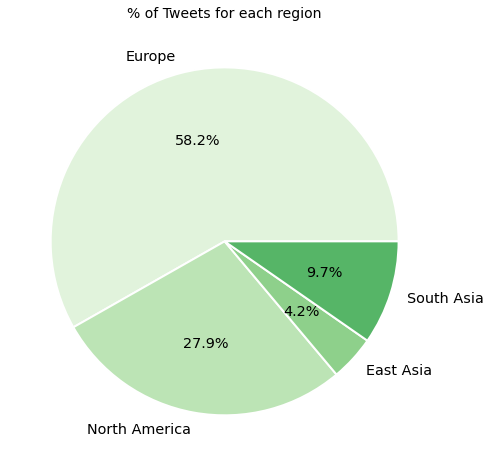

In [ ]:
#count the total tweets of each dataframe
dataframes = {'Europe': EU_Cleaned, 'North America': NA_Cleaned, 'East Asia': AS_Cleaned, 'South Asia': IN_Cleaned}
df_region = pd.DataFrame([(i, df.shape[0]) for i, df in dataframes.items()],
                            columns=['df','count_rows'])

#tweets for each region_plot
fig, ax = plt.subplots(figsize=(12,8))

labels = df_region['df']
colors = sns.color_palette("Greens")

ax.pie(df_region['count_rows'], labels=labels, colors=colors, autopct='%.1f%%',
       wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('% of Tweets for each region', fontsize=14)

plt.show()

*Retweet Count*

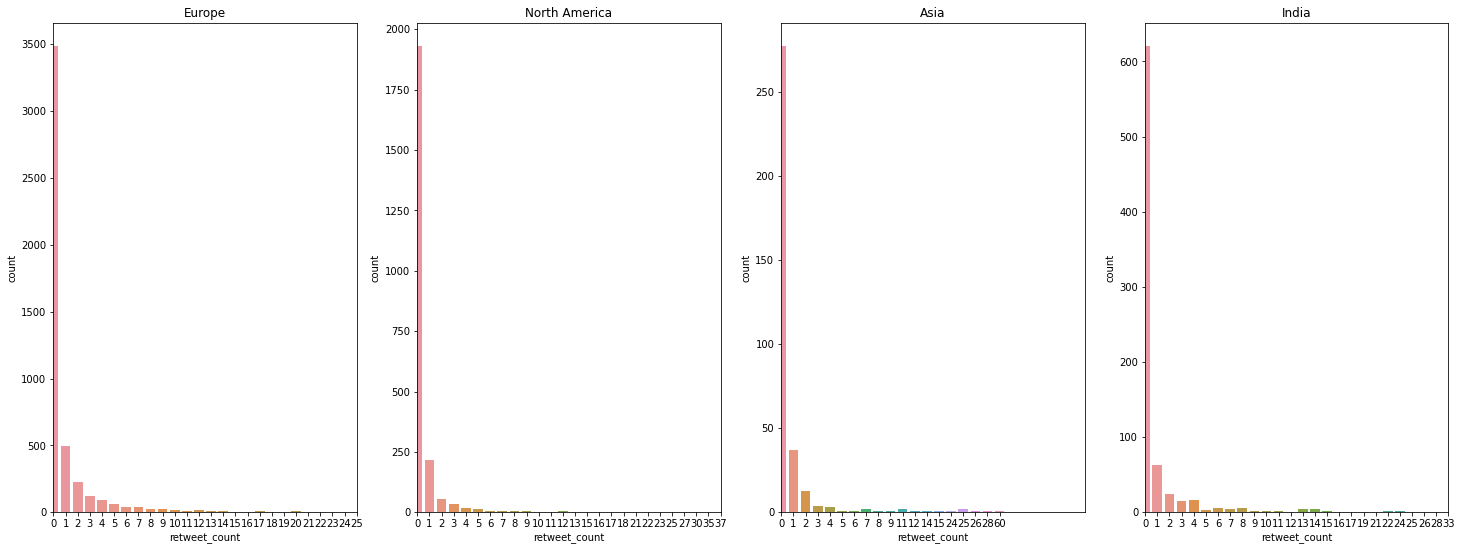

In [ ]:
#retweet_count plots
fig, axs = plt.subplots(1,4, figsize=(25,9))

ax1=sns.countplot(x='retweet_count', data=EU_Cleaned, ax=axs[0])
ax1.set(title='Europe')
ax1.set_xlim([0, 25])

ax2=sns.countplot(x='retweet_count', data=NA_Cleaned, ax=axs[1])
ax2.set(title='North America')
ax2.set_xlim([0, 25])

ax3=sns.countplot(x='retweet_count', data=AS_Cleaned, ax=axs[2])
ax3.set(title='Asia')
ax3.set_xlim([0, 25])

ax4=sns.countplot(x='retweet_count', data=IN_Cleaned, ax=axs[3])
ax4.set(title='India')
ax4.set_xlim([0, 25])

plt.show()

*Favorite Count*

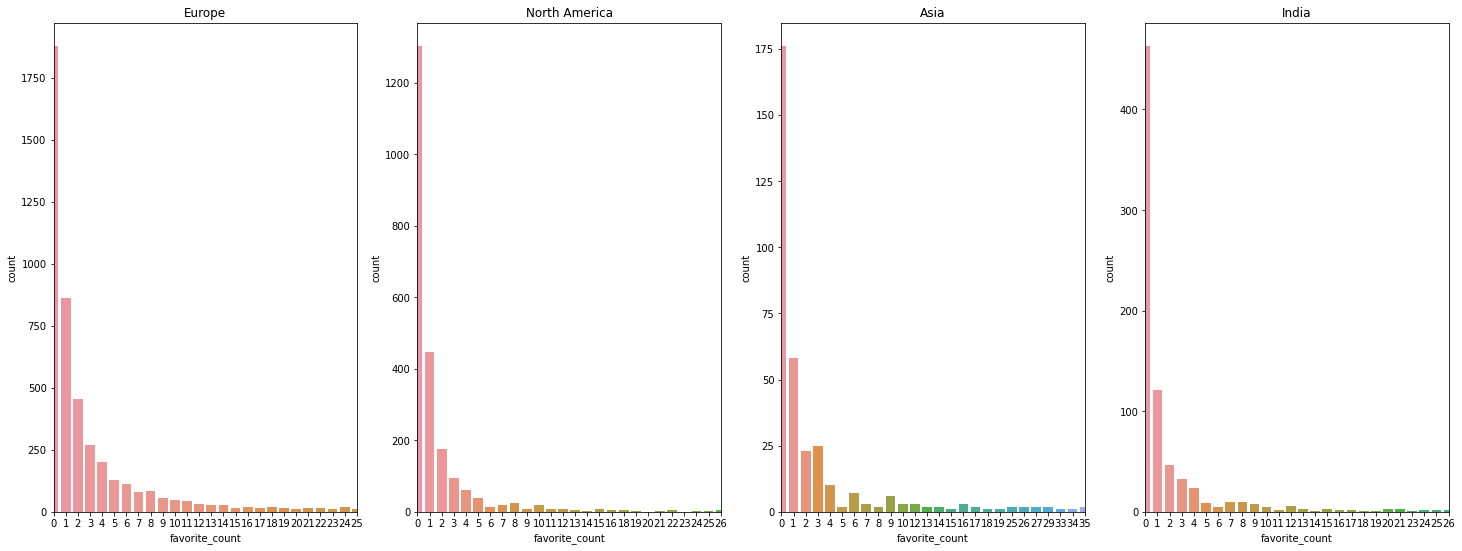

In [ ]:
#favorite_count plots
fig, axs = plt.subplots(1,4, figsize=(25,9))

ax1=sns.countplot(x='favorite_count', data=EU_Cleaned, ax=axs[0])
ax1.set(title='Europe')
ax1.set_xlim([0, 25])

ax2=sns.countplot(x='favorite_count', data=NA_Cleaned, ax=axs[1])
ax2.set(title='North America')
ax2.set_xlim([0, 25])

ax3=sns.countplot(x='favorite_count', data=AS_Cleaned, ax=axs[2])
ax3.set(title='Asia')
ax3.set_xlim([0, 25])

ax4=sns.countplot(x='favorite_count', data=IN_Cleaned, ax=axs[3])
ax4.set(title='India')
ax4.set_xlim([0, 25])

plt.show()

**Most Common Words**

*EU*

In [ ]:
#Most common words
EU_Cleaned['temp_list'] = EU_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in EU_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

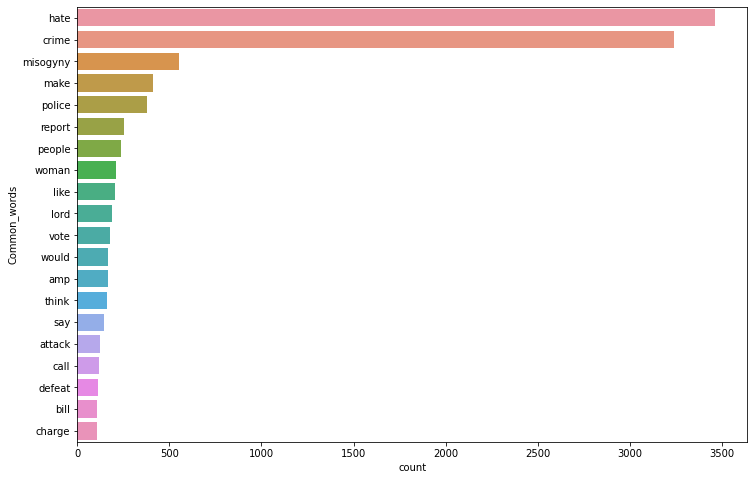

In [ ]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

*NA*

In [ ]:
#Most common words
NA_Cleaned['temp_list'] = NA_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in NA_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

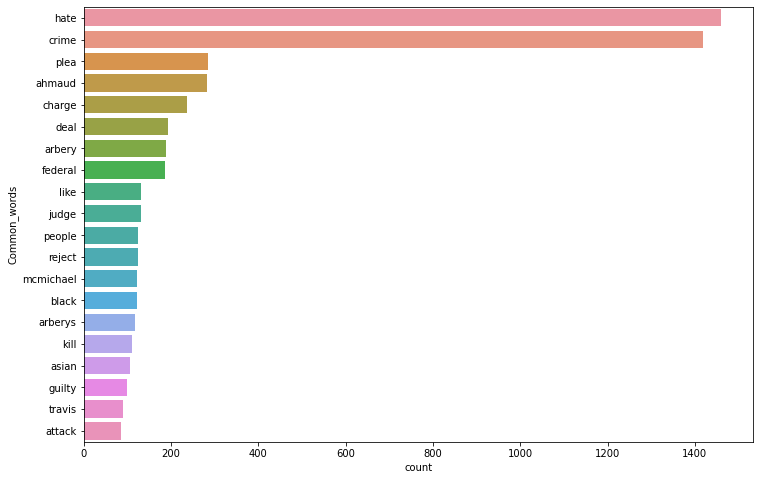

In [ ]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

*AS*

In [ ]:
#Most common words
AS_Cleaned['temp_list'] = AS_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in AS_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

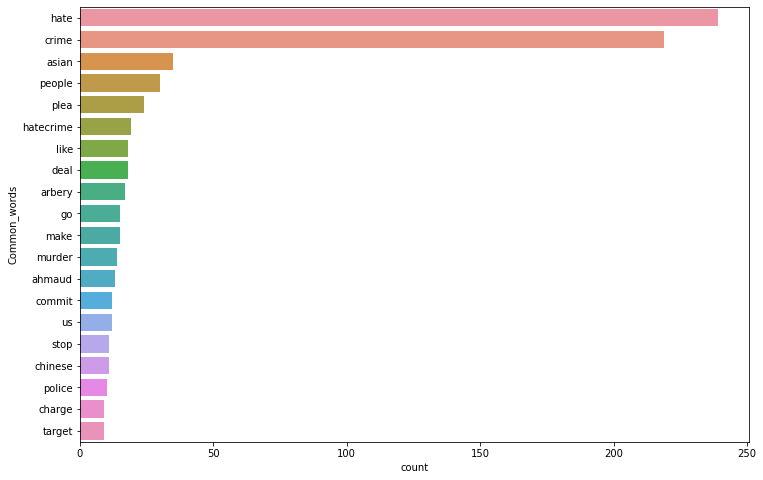

In [ ]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

*IN*

In [ ]:
#Most common words
IN_Cleaned['temp_list'] = IN_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in IN_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

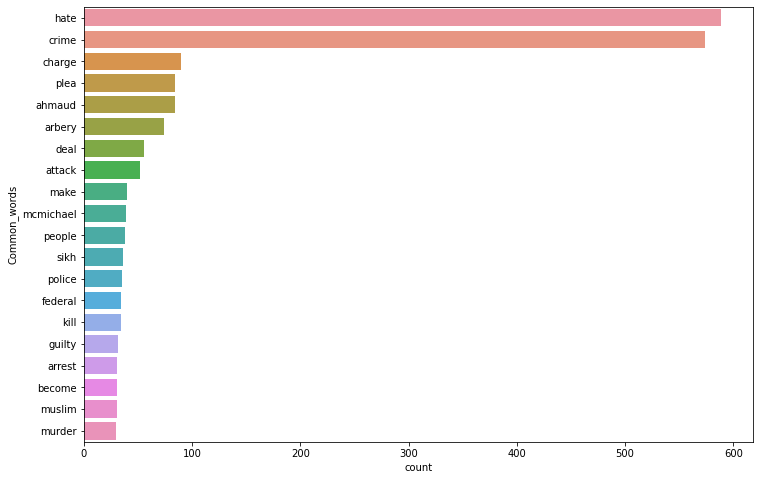

In [ ]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

**Wordclouds**

In [ ]:
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, **kwargs):
    return "hsl(%d, 80%%, 50%%)" % (360 * dictionary[word])
  return my_tf_color_func_inner

*EU*

Normal words


(-0.5, 799.5, 499.5, -0.5)

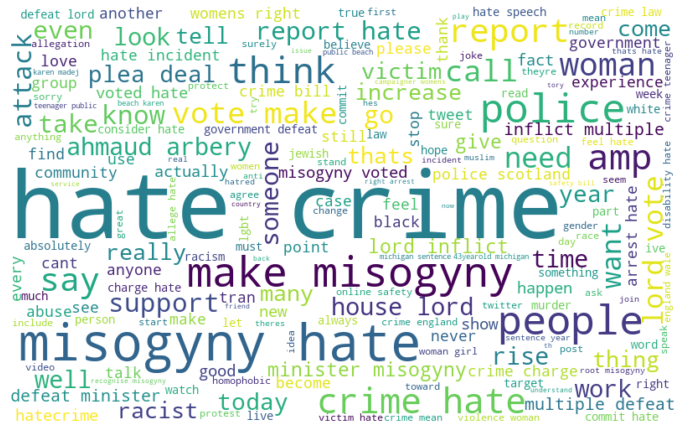

In [ ]:
normal_words = ' '.join([word for word in EU_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

EU Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

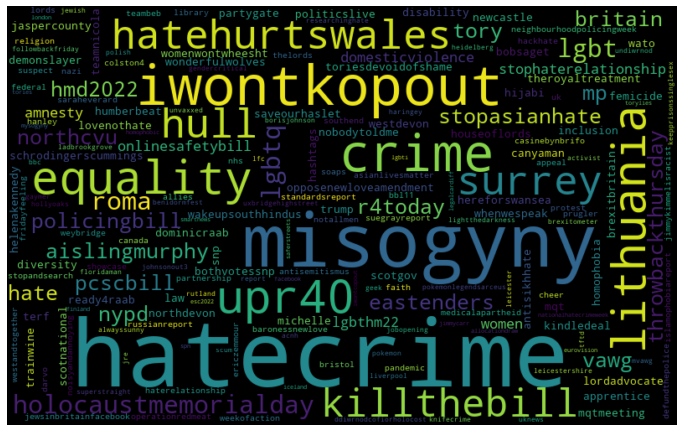

In [ ]:
hashtags = ' '.join([word for word in EU_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear', cmap='Set2')
plt.axis('off')

*NA*

Normal words


(-0.5, 799.5, 499.5, -0.5)

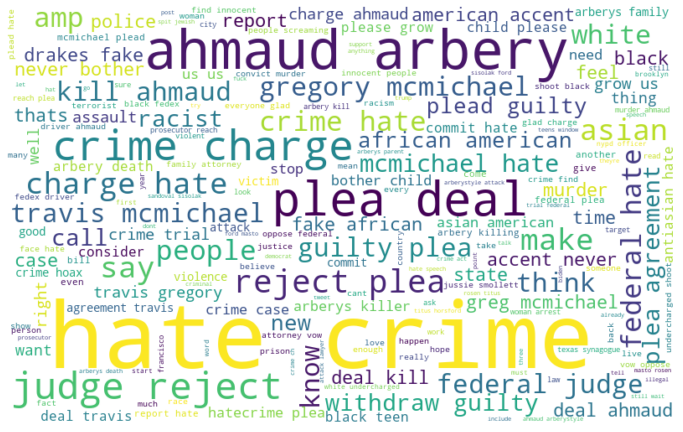

In [ ]:
normal_words = ' '.join([word for word in NA_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

NA Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

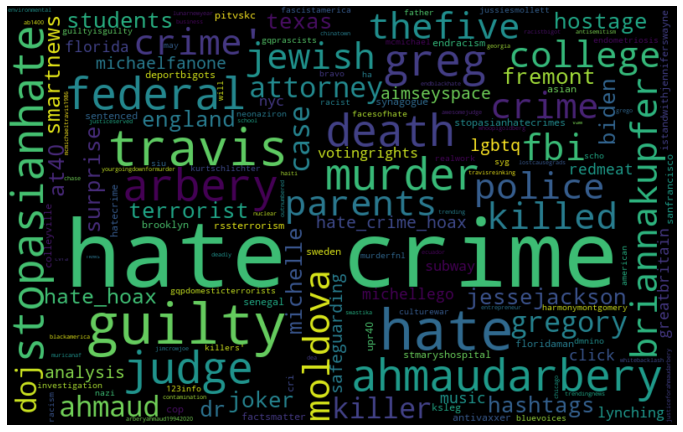

In [ ]:
hashtags = ' '.join([word for word in NA_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='Set2')
plt.axis('off')

*AS*

Normal words


(-0.5, 799.5, 499.5, -0.5)

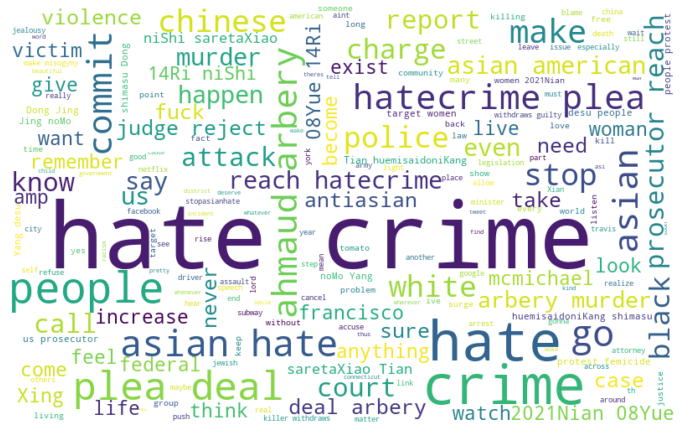

In [ ]:
normal_words = ' '.join([word for word in AS_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

AS Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

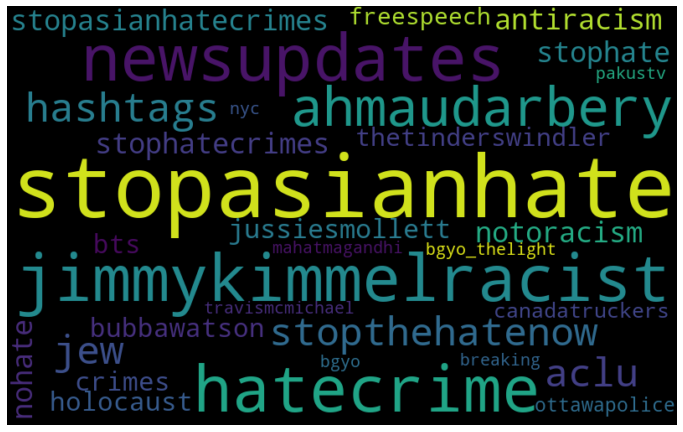

In [ ]:
hashtags = ' '.join([word for word in AS_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='Set2')
plt.axis('off')

*IN*

Normal words


(-0.5, 799.5, 499.5, -0.5)

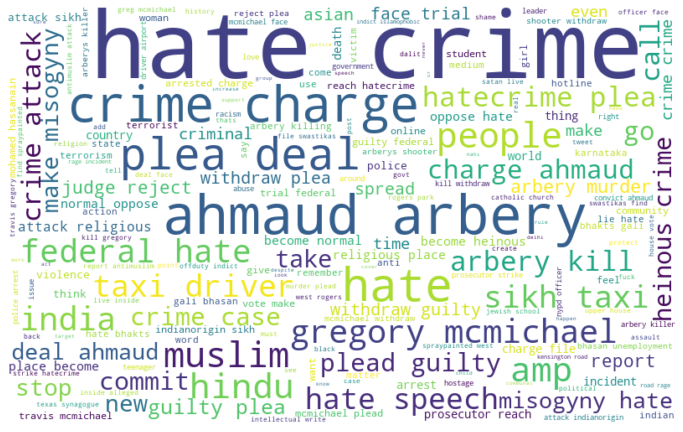

In [ ]:
normal_words = ' '.join([word for word in IN_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

IN Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

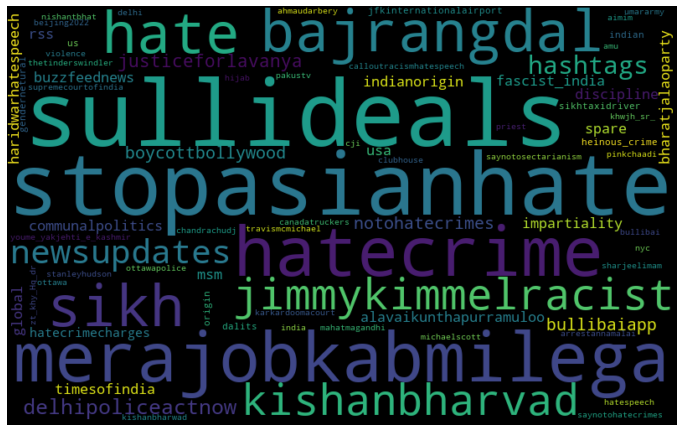

In [ ]:
hashtags = ' '.join([word for word in IN_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 200,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='Set2')
plt.axis('off')

**Vader Sentiment Analysis**
- polarity
- subjectivity
- neg, neu, pos scores
- compound
-sentiment

*Europe*

In [100]:
#Europe
sia = SentimentIntensityAnalyzer()
EU_Cleaned[['polarity', 'subjectivity']] = EU_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(EU_Cleaned['text']):
  ps = sia.polarity_scores(s)
  EU_Cleaned.loc[index,['neg']] = ps['neg']
  EU_Cleaned.loc[index,['neu']] = ps['neu']
  EU_Cleaned.loc[index,['pos']] = ps['pos']
  EU_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    EU_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    EU_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    EU_Cleaned.loc[index,['sentiment']] = 'neutral'
   
EU_Cleaned.head()

text  ...  sentiment
0  A women’s support group chooses not to signpos...  ...   negative
1  You know the worst thing about the hate incide...  ...   negative
2  @GeorgeHotchki14 @HJoyceGender @amscanlon Yup,...  ...   negative
3  @peacelove1967 @ScotCuthbertson Started report...  ...   positive
4  @peacelove1967 @ScotCuthbertson You talk of mu...  ...   negative

[5 rows x 12 columns]

In [ ]:
EU_Cleaned[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound','sentiment']].describe()

polarity  subjectivity  ...          pos     compound
count  4858.000000   4858.000000  ...  4858.000000  4858.000000
mean     -0.373791      0.607563  ...     0.062496    -0.509035
std       0.376253      0.330085  ...     0.092945     0.462066
min      -1.000000      0.000000  ...     0.000000    -0.984000
25%      -0.800000      0.433929  ...     0.000000    -0.835200
50%      -0.400000      0.700000  ...     0.000000    -0.742450
75%       0.000000      0.900000  ...     0.113000    -0.226300
max       1.000000      1.000000  ...     0.881000     0.946000

[8 rows x 6 columns]

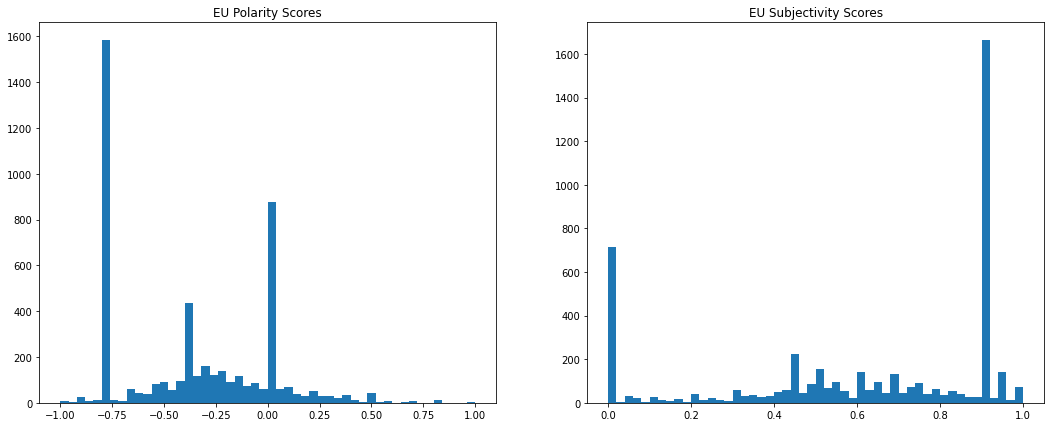

In [ ]:
#EU Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(EU_Cleaned["polarity"], bins = n_bins)
ax1.set_title('EU Polarity Scores')
ax2.hist(EU_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('EU Subjectivity Scores')
plt.show()

Text(0.5, 0, 'Europe Sentiment Result')

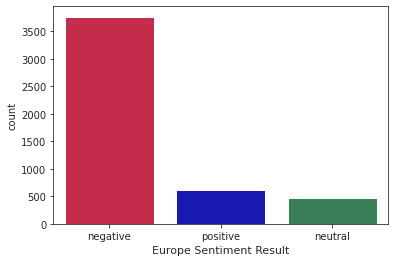

In [ ]:
#EU Counterplot of sentiment
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=EU_Cleaned, palette=["crimson","mediumblue","seagreen"])
ax.set_xlabel('Europe Sentiment Result', fontsize=11)

Text(0.5, 0, 'Europe Sentiment Subjectivity vs. Polarity')

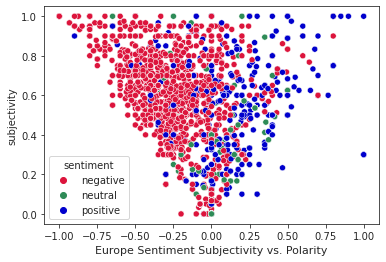

In [ ]:
#EU Sentiment Subjectivity vs. Polarity
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
hue_order = ['negative', 'neutral', 'positive']
ax = sns.scatterplot(data=EU_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax.set_xlabel('Europe Sentiment Subjectivity vs. Polarity', fontsize=11)

*North Amercia*

In [101]:
#North America
sia = SentimentIntensityAnalyzer()
NA_Cleaned[['polarity', 'subjectivity']] = NA_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(NA_Cleaned['text']):
  ps = sia.polarity_scores(s)
  NA_Cleaned.loc[index,['neg']] = ps['neg']
  NA_Cleaned.loc[index,['neu']] = ps['neu']
  NA_Cleaned.loc[index,['pos']] = ps['pos']
  NA_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    NA_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    NA_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    NA_Cleaned.loc[index,['sentiment']] = 'neutral'
   
NA_Cleaned.head()

text  ...         region
0  @TheRevAl @TheRevAl @MeetThePress @FaceTheNati...  ...  North America
1  @nathaliejacoby1 the legal punishment will not...  ...  North America
2  Cooper Kupp out there cookin Niggas  like its ...  ...  North America
3  @angry_gammy @thatdaneshguy Absolutely its a h...  ...  North America
4  @PR_NHL What about racism to white people, we ...  ...  North America

[5 rows x 13 columns]

In [ ]:
NA_Cleaned[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound','sentiment']].describe()

polarity  subjectivity  ...          pos     compound
count  2328.000000   2328.000000  ...  2328.000000  2328.000000
mean     -0.361253      0.575096  ...     0.060290    -0.525556
std       0.374283      0.348047  ...     0.095941     0.450866
min      -1.000000      0.000000  ...     0.000000    -0.975200
25%      -0.800000      0.300000  ...     0.000000    -0.855350
50%      -0.350000      0.666667  ...     0.000000    -0.735100
75%       0.000000      0.900000  ...     0.109250    -0.273200
max       0.800000      1.000000  ...     0.784000     0.967800

[8 rows x 6 columns]

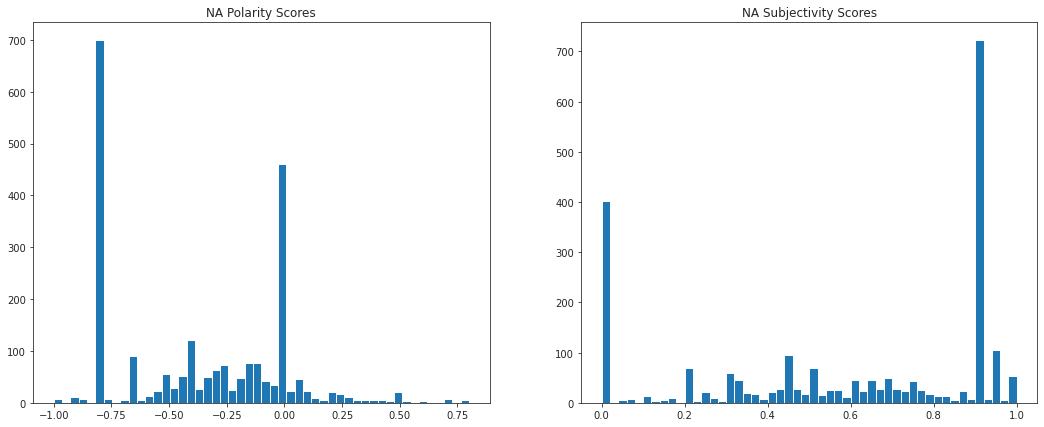

In [ ]:
#NA Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(NA_Cleaned["polarity"], bins = n_bins)
ax1.set_title('NA Polarity Scores')
ax2.hist(NA_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('NA Subjectivity Scores')
plt.show()

Text(0.5, 0, 'North America Sentiment Result')

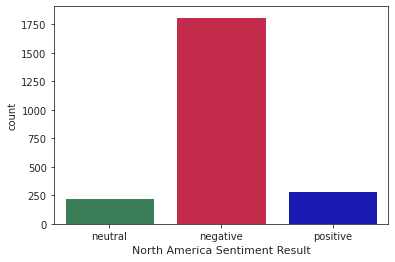

In [ ]:
#NA Countplot of sentiment
#sns.set(rc={'figure.figsize':(10,7)})
#ax = sns.countplot(x="sentiment", data=NA_Cleaned)
#ax.set(xlabel='North America Sentiment Result')
#NA Counterplot of sentiment
#NA Counterplot of sentiment
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=NA_Cleaned, palette=["seagreen","crimson","mediumblue"])
ax.set_xlabel('North America Sentiment Result', fontsize=11)

Text(0.5, 0, 'North America Sentiment Subjectivity vs. Polarity')

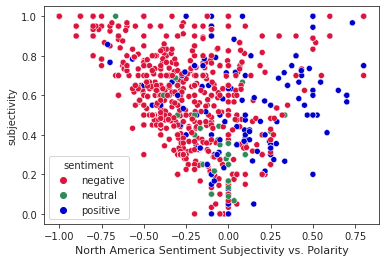

In [ ]:
#NA Sentiment Subjectivity vs. Polarity
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
hue_order = ['negative', 'neutral', 'positive']
ax = sns.scatterplot(data=NA_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax.set_xlabel('North America Sentiment Subjectivity vs. Polarity', fontsize=11)

*Asia*

In [102]:
#Asia
sia = SentimentIntensityAnalyzer()
AS_Cleaned[['polarity', 'subjectivity']] = AS_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(AS_Cleaned['text']):
  ps = sia.polarity_scores(s)
  AS_Cleaned.loc[index,['neg']] = ps['neg']
  AS_Cleaned.loc[index,['neu']] = ps['neu']
  AS_Cleaned.loc[index,['pos']] = ps['pos']
  AS_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    AS_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    AS_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    AS_Cleaned.loc[index,['sentiment']] = 'neutral'
   
AS_Cleaned.head()

text  ...  sentiment
0  District attorney of Connecticut: James be cha...  ...   negative
1  @hongerootooties this is a hate crime cc: @ril...  ...   negative
2  @k_athanasi @FrankPallone Your tweet is a HATE...  ...   negative
3       This is a hate crime https://t.co/Zzfvrvjmft  ...   negative
4                @legendaryadkins this is hate crime  ...   negative

[5 rows x 12 columns]

In [ ]:
AS_Cleaned[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound','sentiment']].describe()

polarity  subjectivity         neg         neu         pos    compound
count  351.000000    351.000000  351.000000  351.000000  351.000000  351.000000
mean    -0.374694      0.569536    0.328550    0.617479    0.053969   -0.535160
std      0.365616      0.353982    0.217424    0.203644    0.089580    0.443997
min     -1.000000      0.000000    0.000000    0.122000    0.000000   -0.963800
25%     -0.800000      0.300000    0.163000    0.493000    0.000000   -0.817400
50%     -0.400000      0.687500    0.336000    0.594000    0.000000   -0.760400
75%      0.000000      0.900000    0.475000    0.750500    0.089000   -0.317300
max      0.800000      1.000000    0.878000    1.000000    0.505000    0.914400

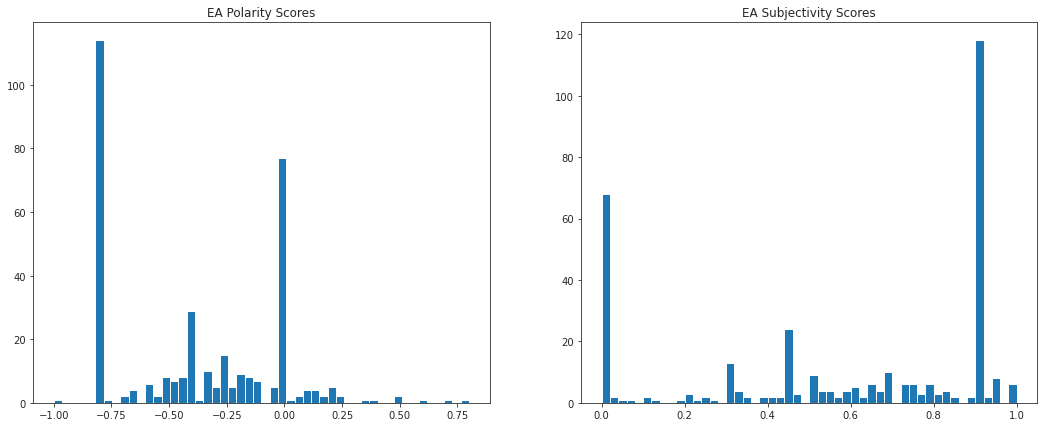

In [ ]:
#AS Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(AS_Cleaned["polarity"], bins = n_bins)
ax1.set_title('EA Polarity Scores')
ax2.hist(AS_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('EA Subjectivity Scores')
plt.show()

Text(0.5, 0, 'East Asia Sentiment Result')

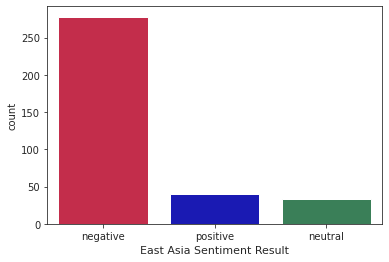

In [ ]:
#AS Countplot of sentiment
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=AS_Cleaned, palette=["crimson","mediumblue","seagreen"])
ax.set_xlabel('East Asia Sentiment Result', fontsize=11)

Text(0.5, 0, 'East Asia Sentiment Subjectivity vs. Polarity')

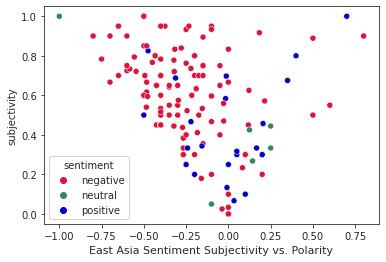

In [ ]:
#AS Sentiment Subjectivity vs. Polarity
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
hue_order = ['negative', 'neutral', 'positive']
ax = sns.scatterplot(data=AS_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax.set_xlabel('East Asia Sentiment Subjectivity vs. Polarity', fontsize=11)

*India*

In [103]:
#India
sia = SentimentIntensityAnalyzer()
IN_Cleaned[['polarity', 'subjectivity']] = IN_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(IN_Cleaned['text']):
  ps = sia.polarity_scores(s)
  IN_Cleaned.loc[index,['neg']] = ps['neg']
  IN_Cleaned.loc[index,['neu']] = ps['neu']
  IN_Cleaned.loc[index,['pos']] = ps['pos']
  IN_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    IN_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    IN_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    IN_Cleaned.loc[index,['sentiment']] = 'neutral'
   
IN_Cleaned.head()

text  ...  sentiment
0  @Hate_Congress @AminaaKausar Death sentence fo...  ...   negative
1  @Hate_Congress @AminaaKausar Crime is crime . ...  ...   negative
2  @DiwakarSharmaa @ShivRajMathur1 Now they are a...  ...   negative
3  I hate this bitch, she'll befriend u, turn u t...  ...   negative
4  @FaissalFarooq @Nidhi What these guys ve alleg...  ...   negative

[5 rows x 12 columns]

In [ ]:
IN_Cleaned[['polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound','sentiment']].describe()

polarity  subjectivity         neg         neu         pos    compound
count  807.000000    807.000000  807.000000  807.000000  807.000000  807.000000
mean    -0.417770      0.611828    0.355230    0.595530    0.049237   -0.607439
std      0.358782      0.337453    0.204884    0.194278    0.085864    0.417714
min     -1.000000      0.000000    0.000000    0.122000    0.000000   -0.975800
25%     -0.800000      0.400000    0.214500    0.457000    0.000000   -0.882800
50%     -0.400000      0.725000    0.379000    0.571000    0.000000   -0.802000
75%     -0.050000      0.900000    0.503500    0.711000    0.094000   -0.514700
max      0.800000      1.000000    0.878000    1.000000    0.679000    0.888500

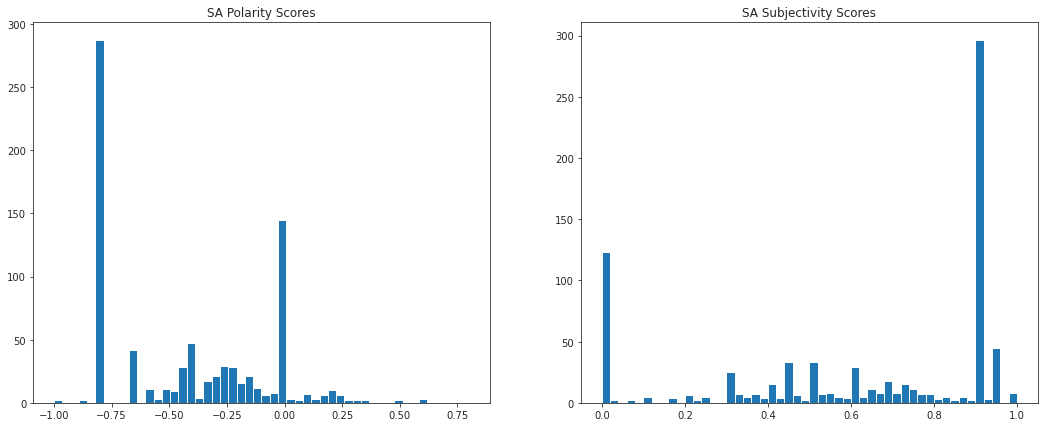

In [ ]:
#IN Histograms of polarity and subjectivity
sns.set_style('ticks')
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(IN_Cleaned["polarity"], bins = n_bins)
ax1.set_title('SA Polarity Scores')
ax2.hist(IN_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('SA Subjectivity Scores')
plt.show()

Text(0.5, 0, 'South Asia Sentiment Result')

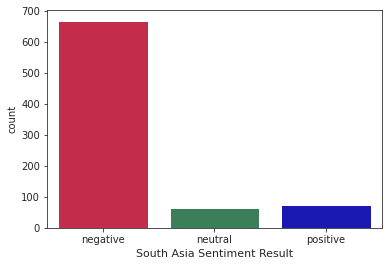

In [ ]:
#IN Countplot of sentiment
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=IN_Cleaned, palette=["crimson","seagreen","mediumblue"])
ax.set_xlabel('South Asia Sentiment Result', fontsize=11)

Text(0.5, 0, 'South Asia Sentiment Subjectivity vs. Polarity')

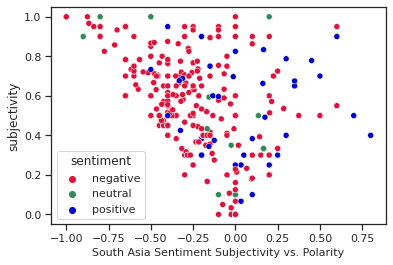

In [123]:
#IN Sentiment Subjectivity vs. Polarity
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
hue_order = ['negative', 'neutral', 'positive']
ax = sns.scatterplot(data=IN_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax.set_xlabel('South Asia Sentiment Subjectivity vs. Polarity', fontsize=11)

In [104]:
AS_Cleaned['region'] ='East Asia'
EU_Cleaned['region'] ='Europe'
NA_Cleaned['region'] ='North America'
IN_Cleaned['region'] ='South Asia'

In [106]:
#Concat regions into the same dataframe
frames = [AS_Cleaned, EU_Cleaned, NA_Cleaned, IN_Cleaned]
  
combine_df = pd.concat(frames, ignore_index=True)
display(combine_df)

text  ...      region
0     District attorney of Connecticut: James be cha...  ...   East Asia
1     @hongerootooties this is a hate crime cc: @ril...  ...   East Asia
2     @k_athanasi @FrankPallone Your tweet is a HATE...  ...   East Asia
3          This is a hate crime https://t.co/Zzfvrvjmft  ...   East Asia
4                   @legendaryadkins this is hate crime  ...   East Asia
...                                                 ...  ...         ...
8339  Prosecutors Strike Hate-Crime Plea Deals in Ah...  ...  South Asia
8340  Plot twist, it’s not a hate crime sebab cashie...  ...  South Asia
8341  @SharjeelUsmani Being anti Hindu &amp; anti co...  ...  South Asia
8342  I never realized that loving yourself is a cri...  ...  South Asia
8343  I’m sure creating a hashtag called KLUTRUXKLAN...  ...  South Asia

[8344 rows x 13 columns]

***Combined Graphs***

*Sentiment for all region*

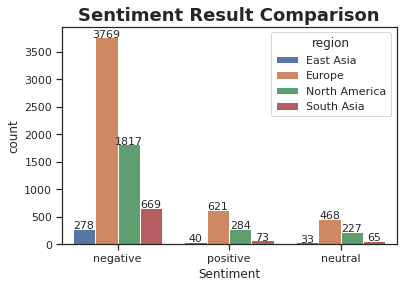

In [124]:
sns.set_style('ticks', rc={'figure.figsize':(10,15)})
ax = sns.countplot(x="sentiment", hue="region", data= combine_df)
ax.set_title('Sentiment Result Comparison',fontsize = 18, fontweight='bold' )
ax.set(xlabel='Sentiment')
#show count
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

Text(0.5, 8.95999999999998, 'Sentiment')

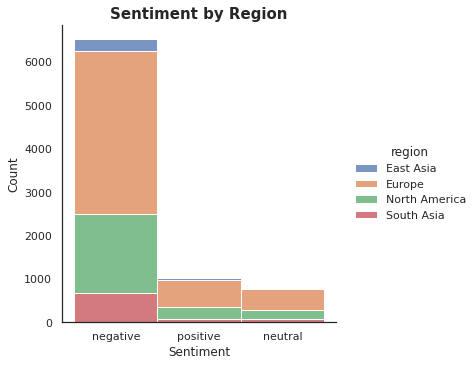

In [120]:
#stack bar
sns.displot(data=combine_df, x="sentiment", hue="region", multiple="stack")
plt.title('Sentiment by Region', fontsize = 15, fontweight='bold' )
plt.xlabel('Sentiment')

Text(0.5, 0.98, 'Distribution of Sentiment by Region')

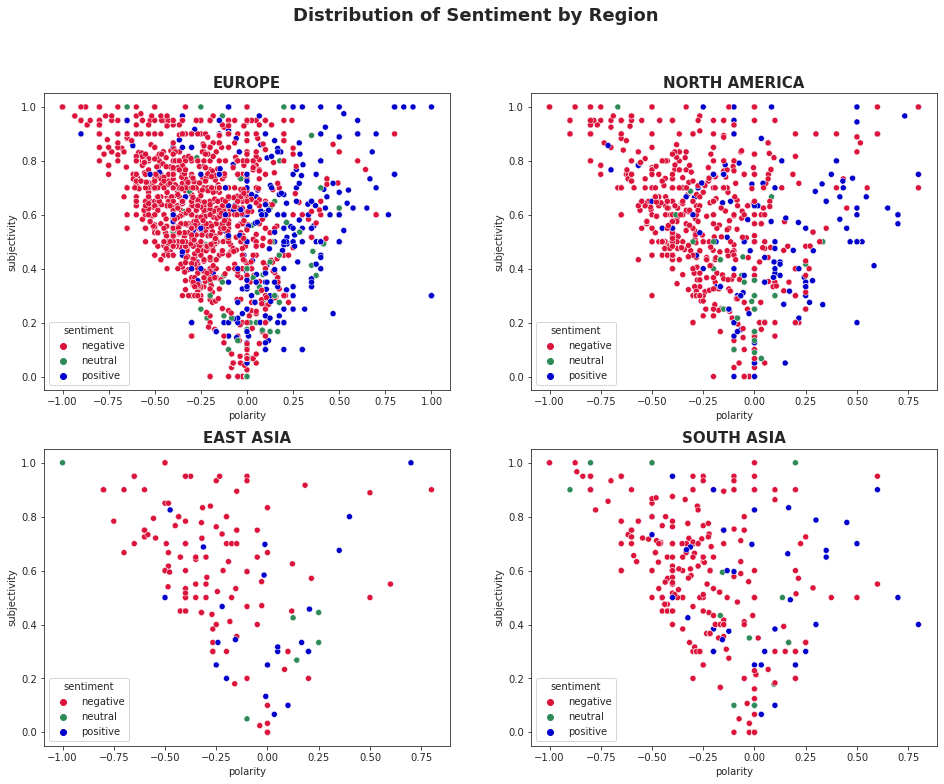

In [ ]:
#scatter plot
hue_order = ['negative', 'neutral', 'positive']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))

ax1 = sns.scatterplot(ax=ax1, data=EU_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax2 = sns.scatterplot(ax=ax2,data=NA_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax3 = sns.scatterplot(ax=ax3,data=AS_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax4 = sns.scatterplot(ax=ax4,data=IN_Cleaned, x="polarity", y="subjectivity", hue="sentiment", hue_order=hue_order, palette=["crimson","seagreen","mediumblue"])
ax1.set_title("EUROPE", fontsize = 15, fontweight='bold')
ax2.set_title("NORTH AMERICA", fontsize = 15, fontweight='bold')
ax3.set_title("EAST ASIA", fontsize = 15, fontweight='bold')
ax4.set_title("SOUTH ASIA", fontsize = 15, fontweight='bold')
fig.suptitle('Distribution of Sentiment by Region',fontsize = 18, fontweight='bold')

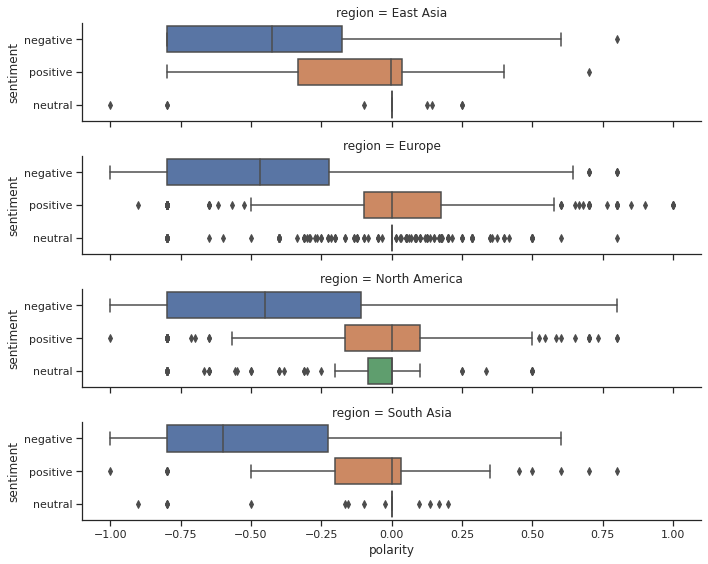

In [125]:
sns.set_style('ticks', rc={'figure.figsize':(10,7)})
ax = sns.catplot(x="polarity", y="sentiment", row="region", kind="box", orient="h", height=2, aspect=5, data=combine_df, ci='sd')

*Count Comparison for Subjectivity and Polarity*

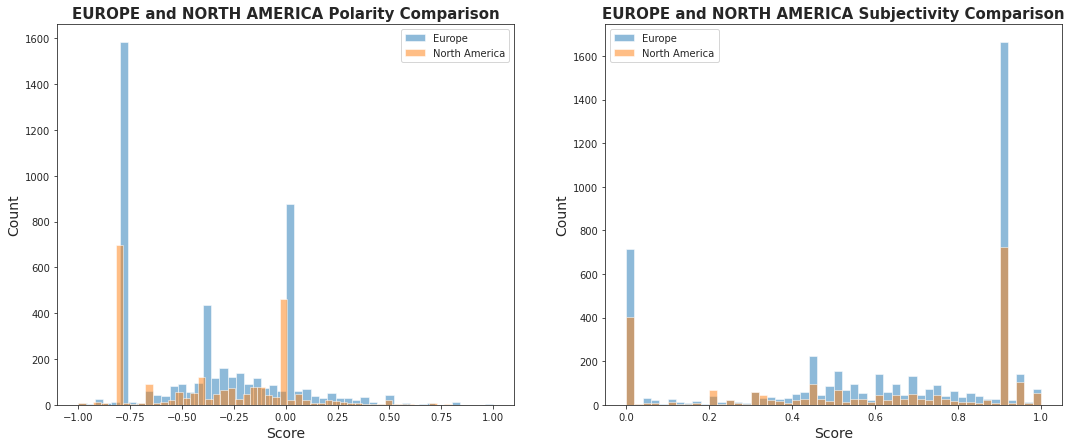

In [ ]:
#EU NA Count comparison
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(EU_Cleaned["polarity"], alpha=0.5, bins = n_bins, label="Europe")
ax1.hist(NA_Cleaned["polarity"], alpha=0.5, bins = n_bins, label="North America")
ax1.set_title("EUROPE and NORTH AMERICA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Count", size=14)
ax1.legend(loc='upper right')

ax2.hist(EU_Cleaned["subjectivity"], alpha=0.5, bins = n_bins, label="Europe")
ax2.hist(NA_Cleaned["subjectivity"], alpha=0.5, bins = n_bins, label="North America")
ax2.set_title("EUROPE and NORTH AMERICA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Count", size=14)
ax2.legend(loc='upper left')

*Probability Comparison for Subjectivity and Polarity*

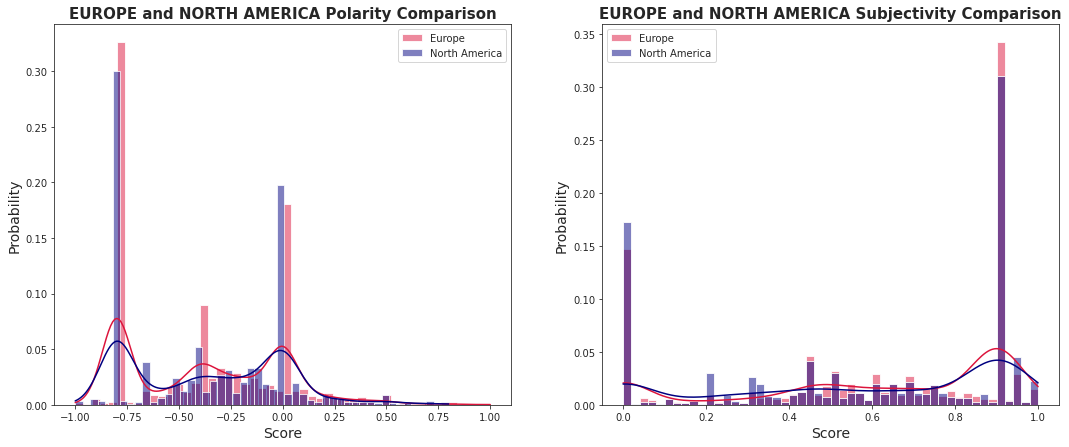

In [ ]:
#EU NA Probability
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
sns.histplot(ax=ax1, data=EU_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="Europe", color="crimson")
sns.histplot(ax=ax1, data=NA_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="North America", color="navy")
ax1.set_title("EUROPE and NORTH AMERICA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Probability", size=14)
ax1.legend(loc='upper right')

sns.histplot(ax=ax2, data=EU_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="Europe", color="crimson")
sns.histplot(ax=ax2, data=NA_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="North America", color="navy")
ax2.set_title("EUROPE and NORTH AMERICA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Probability", size=14)
ax2.legend(loc='upper left')

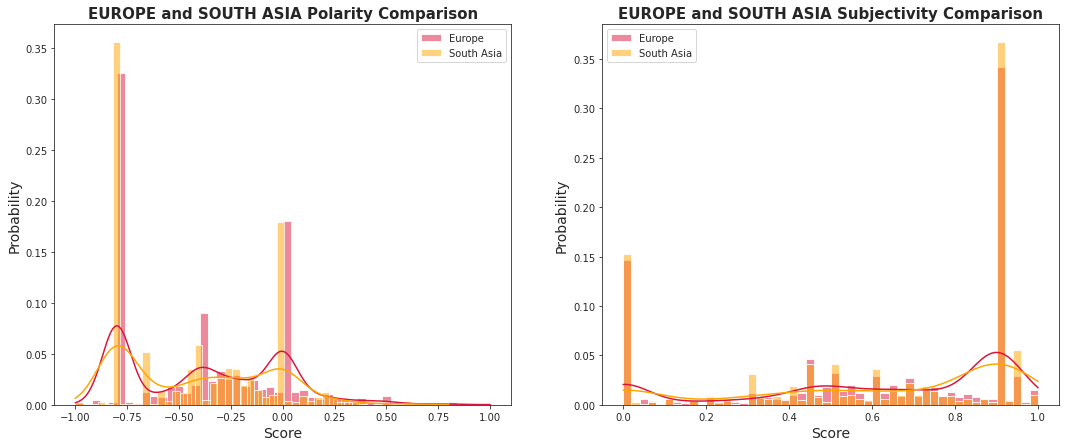

In [ ]:
#EU IN Probability
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
sns.histplot(ax=ax1, data=EU_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="Europe", color="crimson")
sns.histplot(ax=ax1, data=IN_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="South Asia", color="orange")
ax1.set_title("EUROPE and SOUTH ASIA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Probability", size=14)
ax1.legend(loc='upper right')

sns.histplot(ax=ax2, data=EU_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="Europe", color="crimson")
sns.histplot(ax=ax2, data=IN_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="South Asia", color="orange")
ax2.set_title("EUROPE and SOUTH ASIA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Probability", size=14)
ax2.legend(loc='upper left')

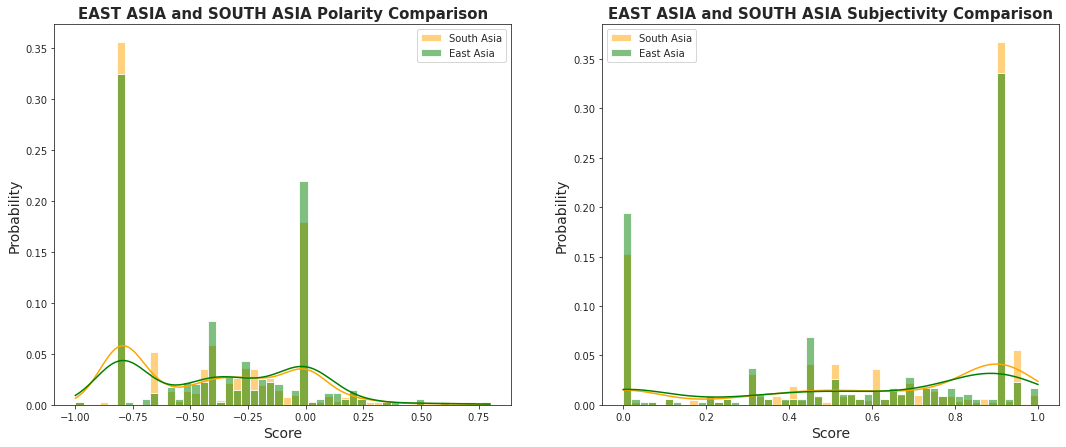

In [ ]:
#AS IN Probability
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
sns.histplot(ax=ax1, data=IN_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="South Asia", color="orange")
sns.histplot(ax=ax1, data=AS_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="East Asia", color="green")
ax1.set_title("EAST ASIA and SOUTH ASIA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Probability", size=14)
ax1.legend(loc='upper right')

sns.histplot(ax=ax2, data=IN_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="South Asia", color="orange")
sns.histplot(ax=ax2, data=AS_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="East Asia", color="green")
ax2.set_title("EAST ASIA and SOUTH ASIA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Probability", size=14)
ax2.legend(loc='upper left')

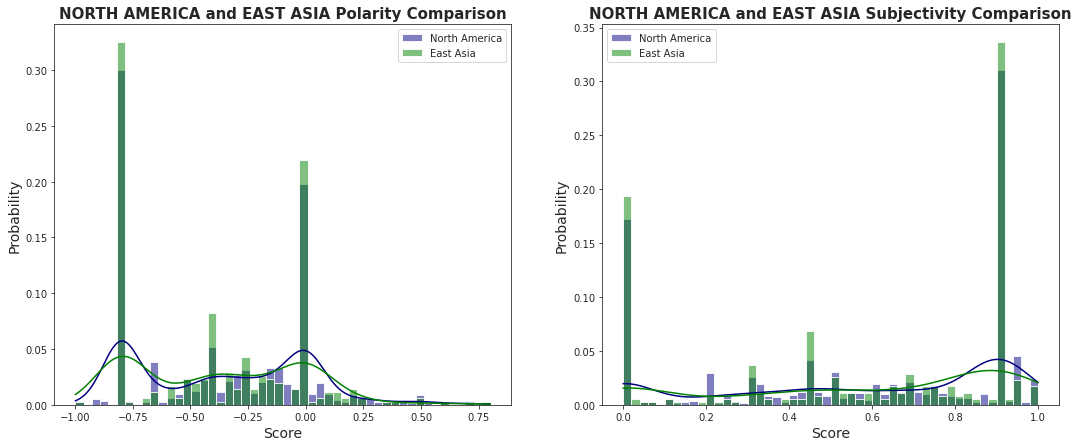

In [ ]:
#NA AS Probability
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
sns.histplot(ax=ax1, data=NA_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="North America", color="navy")
sns.histplot(ax=ax1, data=AS_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="East Asia", color="green")
ax1.set_title("NORTH AMERICA and EAST ASIA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Probability", size=14)
ax1.legend(loc='upper right')

sns.histplot(ax=ax2, data=NA_Cleaned, x="subjectivity", stat="probability", kde=True, bins=n_bins, label="North America", color="navy")
sns.histplot(ax=ax2, data=AS_Cleaned, x="subjectivity", stat="probability", kde=True, bins=n_bins, label="East Asia", color="green")
ax2.set_title("NORTH AMERICA and EAST ASIA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Probability", size=14)
ax2.legend(loc='upper left')

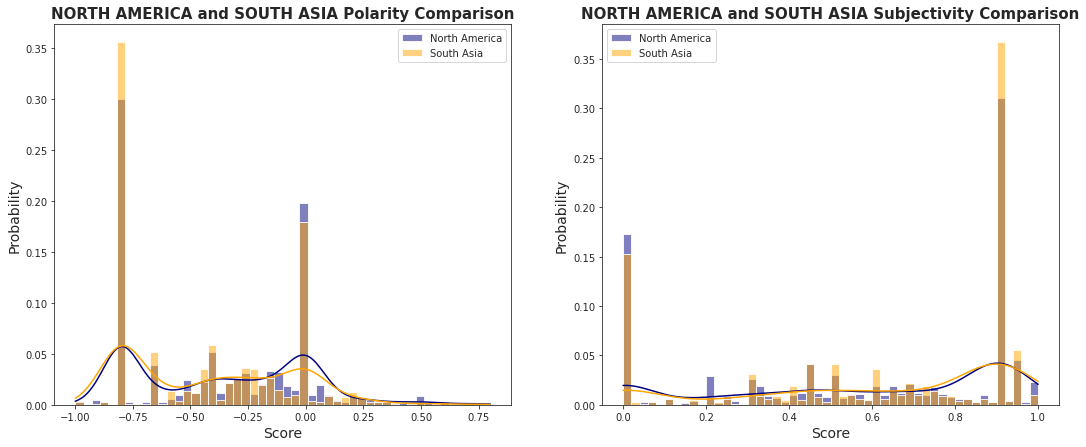

In [ ]:
#NA IN Probability
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
sns.histplot(ax=ax1, data=NA_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="North America", color="navy")
sns.histplot(ax=ax1, data=IN_Cleaned, x="polarity", stat="probability", kde=True, bins=n_bins, label="South Asia", color="orange")
ax1.set_title("NORTH AMERICA and SOUTH ASIA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Probability", size=14)
ax1.legend(loc='upper right')

sns.histplot(ax=ax2, data=NA_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="North America", color="navy")
sns.histplot(ax=ax2, data=IN_Cleaned, x="subjectivity", stat="probability", kde=True, bins = n_bins, label="South Asia", color="orange")
ax2.set_title("NORTH AMERICA and SOUTH ASIA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Probability", size=14)
ax2.legend(loc='upper left')

*Average Subjectivity and Polarity*

In [134]:
#Average value by region
avg_df = combine_df.groupby(['region']).mean().reset_index()
avg_df

region  retweet_count  favorite_count  ...       neu       pos  compound
0      East Asia       1.082621        5.769231  ...  0.617479  0.053969 -0.535160
1         Europe       5.163442       23.708934  ...  0.636253  0.062496 -0.509035
2  North America       1.596220        6.770619  ...  0.625468  0.060290 -0.525556
3     South Asia       3.890954       11.111524  ...  0.595530  0.049237 -0.607439

[4 rows x 9 columns]

In [135]:
avg_df2 = avg_df[['region','polarity', 'subjectivity']]
avg_df2

region  polarity  subjectivity
0      East Asia -0.374694      0.569536
1         Europe -0.373791      0.607563
2  North America -0.361253      0.575096
3     South Asia -0.417770      0.611828

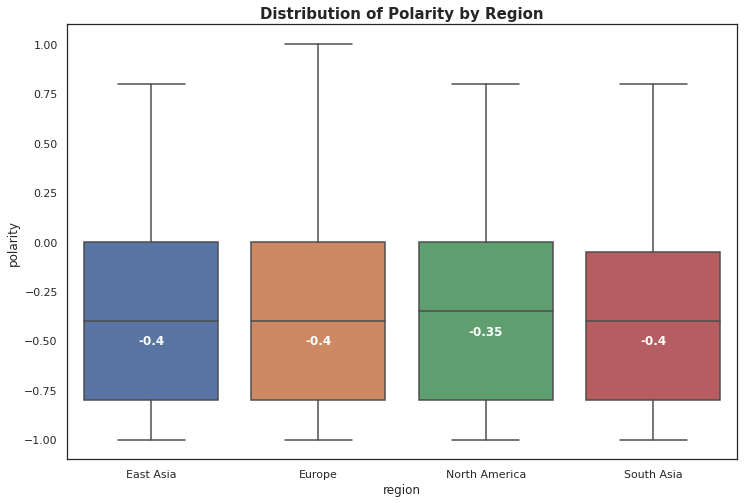

In [121]:
# Boxplot for polarity by region
#col = {"East Asia": "green", "Europe": "crimson", "North America":"royalblue", "South Asia":"orange"}
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(data=combine_df, x='region', y='polarity')
'''showmeans=True,
meanprops={"marker":"o",
"markerfacecolor":"lightgrey", 
"markeredgecolor":"lightgrey",
"markersize":"7"}'''
ax.set_title("Distribution of Polarity by Region", fontsize = 15, fontweight='bold')

medians = combine_df.groupby(['region'])['polarity'].median()
medians = round(medians, 2)
vertical_offset = combine_df['polarity'].median() * 0.3 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center', size='medium',color='w',weight='semibold')

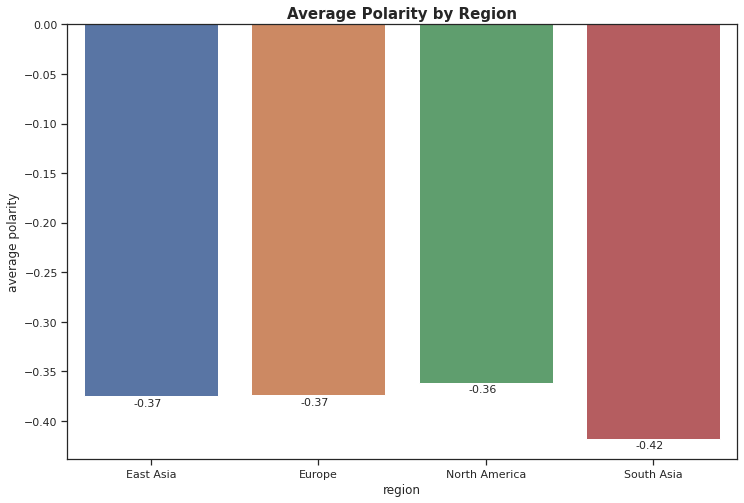

In [164]:
# Average polarity by region
plt.figure(figsize=(12,8))
ax = sns.barplot(x='region', y="polarity", data=avg_df, ci="sd")
ax.set_title("Average Polarity by Region", fontsize = 15, fontweight='bold')
ax.set_ylabel("average polarity")
# data label
#https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots/39621872#39621872
x_offset = -0.02
y_offset = -0.01
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), horizontalalignment='center', fontsize = 11)

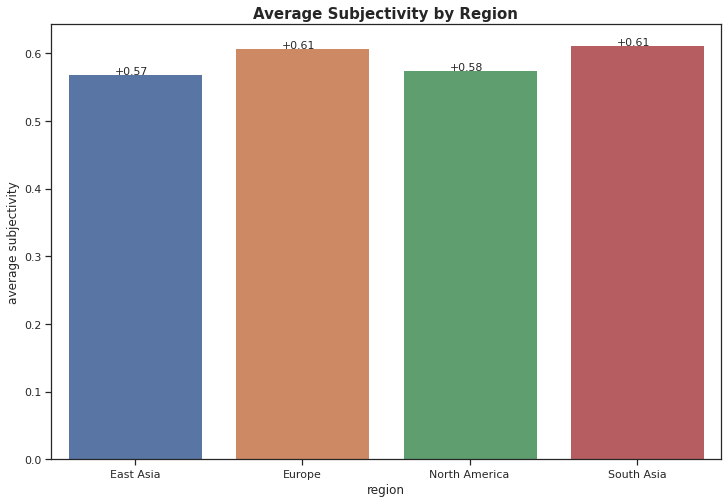

In [168]:
# Average subjectivity by region
plt.figure(figsize=(12,8))
ax = sns.barplot(x='region', y="subjectivity", data=avg_df, ci="sd")
ax.set_title("Average Subjectivity by Region", fontsize = 15, fontweight='bold')
ax.set_ylabel("average subjectivity")
# data label
x_offset = -0.02
y_offset = 0.00
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), horizontalalignment='center', fontsize = 11)

In [169]:
def pol_bucket(x):
    if x >= 0.37:
        bucket = 'Positive'
    elif 0.37 > x >= -0.37:
        bucket = 'Neutral'
    else:
        bucket = 'Negative'
    return bucket

def sub_bucket(x):
    if x >= 0.60:
        bucket = 'Strong Subjectivity'
    elif 0.60 > x >= 0.30:
        bucket = 'Subjectivity'
    else:
        bucket = 'Weak Subjectivity'
    return bucket

In [170]:
# Create buckets for polarity and subjectivity
avg_df2['pol_bucket'] = avg_df2['polarity'].apply(pol_bucket)
avg_df2['sub_bucket'] = avg_df2['subjectivity'].apply(sub_bucket)
avg_df2

region  polarity  subjectivity pol_bucket           sub_bucket
0      East Asia -0.374694      0.569536   Negative         Subjectivity
1         Europe -0.373791      0.607563   Negative  Strong Subjectivity
2  North America -0.361253      0.575096    Neutral         Subjectivity
3     South Asia -0.417770      0.611828   Negative  Strong Subjectivity

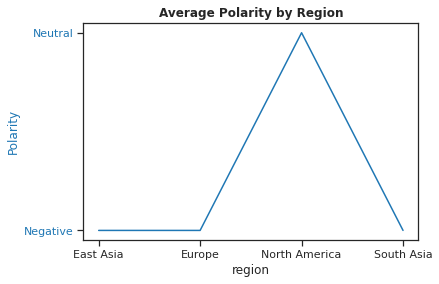

In [171]:
#Polarity

fig, ax = plt.subplots()
sns.set_theme(style="ticks")

color = 'tab:blue'
ax.set_xlabel('region')
ax.set_ylabel('Polarity', color = color)
ax.plot(avg_df2['region'], avg_df2['pol_bucket'], color = color)
ax.tick_params(axis ='y', labelcolor = color)

plt.title('Average Polarity by Region', fontweight ="bold")

plt.show()

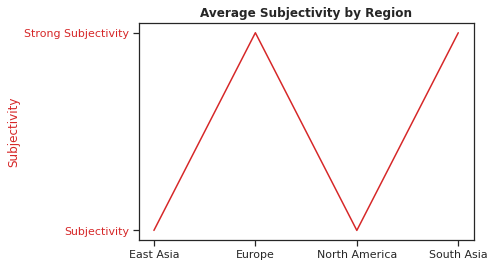

In [172]:
#Subjectivity

fig, ax = plt.subplots()
sns.set_theme(style="ticks")
 
color = 'tab:red'
ax.set_ylabel('Subjectivity', color = color)
ax.plot(avg_df2['region'], avg_df2['sub_bucket'], color = color)
ax.tick_params(axis ='y', labelcolor = color)

plt.title('Average Subjectivity by Region', fontweight ="bold")

plt.show()

***Compound Score Comparison***

In [114]:
#count the total tweets of each dataframe
dataframes = {'Europe': EU_Cleaned, 'North America': NA_Cleaned, 'East Asia': AS_Cleaned, 'South Asia': IN_Cleaned}
df_compound = pd.DataFrame([(i, df.compound.mean()) for i, df in dataframes.items()],
                            columns=['Region','mean_compound'])
df_compound

Region  mean_compound
0         Europe      -0.509035
1  North America      -0.525556
2      East Asia      -0.535160
3     South Asia      -0.607439

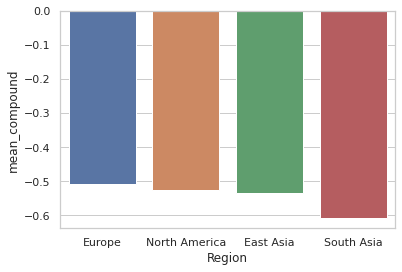

In [115]:
#EU Countplot of sentiment
#sns.set(rc={'figure.figsize':(10,7)})
sns.set_theme(style="whitegrid")
#tips = sns.load_dataset("tips")
sns.barplot(y="mean_compound", x="Region", data=df_compound)

Compound score is a metric lies between [-1.0, 1.0], -1 as the most extreme negative score and +1 as the most extreme positive score. 

# Emo Analysis

### EU

In [28]:
EU_Cleaned.reset_index(inplace = True)

In [29]:
import text2emotion as t2e

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Merlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Merlin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Merlin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
emoList = []

for i in range(EU_Cleaned.shape[0]):
    emoDict = t2e.get_emotion(EU_Cleaned['clean_tweet'][i])
    emoList.append(emoDict)

In [31]:
EU_Cleaned['emotion'] = emoList

In [32]:
EUdataFinalWithEmo = pd.concat([EU_Cleaned, pd.DataFrame(list(EU_Cleaned['emotion']))], axis=1)

In [33]:
EUdataEmo = EUdataFinalWithEmo

In [34]:
EUdataEmo['dominantEmotion'] = EUdataEmo.iloc[:,[7,8,9,10,11]].idxmax(1)

In [35]:
EUdataEmo.groupby('dominantEmotion')['emotion'].count()

dominantEmotion
Angry        224
Fear         440
Happy        874
Sad         4368
Surprise     578
Name: emotion, dtype: int64

### NA

In [37]:
NA_Cleaned.reset_index(inplace = True)

In [38]:
import text2emotion as t2e

In [39]:
emoList = []

for i in range(NA_Cleaned.shape[0]):
    emoDict = t2e.get_emotion(NA_Cleaned['clean_tweet'][i])
    emoList.append(emoDict)

In [40]:
NA_Cleaned['emotion'] = emoList

In [41]:
NAdataFinalWithEmo = pd.concat([NA_Cleaned, pd.DataFrame(list(NA_Cleaned['emotion']))], axis=1)

In [42]:
NAdataEmo = NAdataFinalWithEmo

In [43]:
NAdataEmo['dominantEmotion'] = NAdataEmo.iloc[:,[7,8,9,10,11]].idxmax(1)

In [44]:
NAdataEmo.groupby('dominantEmotion')['emotion'].count()

dominantEmotion
Angry        108
Fear         283
Happy        379
Sad         1945
Surprise     294
Name: emotion, dtype: int64

### Asia

In [46]:
AS_Cleaned.reset_index(inplace = True)

In [47]:
import text2emotion as t2e

In [48]:
emoList = []

for i in range(AS_Cleaned.shape[0]):
    emoDict = t2e.get_emotion(AS_Cleaned['clean_tweet'][i])
    emoList.append(emoDict)

In [49]:
AS_Cleaned['emotion'] = emoList

In [50]:
ASdataFinalWithEmo = pd.concat([AS_Cleaned, pd.DataFrame(list(AS_Cleaned['emotion']))], axis=1)

In [51]:
ASdataEmo = ASdataFinalWithEmo

In [52]:
ASdataEmo['dominantEmotion'] = ASdataEmo.iloc[:,[7,8,9,10,11]].idxmax(1)

In [53]:
ASdataEmo.groupby('dominantEmotion')['emotion'].count()

dominantEmotion
Angry         2
Fear         35
Happy        66
Sad         283
Surprise     49
Name: emotion, dtype: int64

### India

In [55]:
Ind_Cleaned.reset_index(inplace = True)

In [56]:
import text2emotion as t2e

In [57]:
emoList = []

for i in range(Ind_Cleaned.shape[0]):
    emoDict = t2e.get_emotion(Ind_Cleaned['clean_tweet'][i])
    emoList.append(emoDict)

In [58]:
Ind_Cleaned['emotion'] = emoList

In [59]:
InddataFinalWithEmo = pd.concat([Ind_Cleaned, pd.DataFrame(list(Ind_Cleaned['emotion']))], axis=1)

In [60]:
InddataEmo = InddataFinalWithEmo

In [61]:
InddataEmo['dominantEmotion'] = InddataEmo.iloc[:,[7,8,9,10,11]].idxmax(1)

In [62]:
InddataEmo.groupby('dominantEmotion').count()

index  text  retweet_count  favorite_count  clean_tweet  \
dominantEmotion                                                            
Angry               16    16             16              16           16   
Fear                81    81             81              81           81   
Happy              119   119            119             119          119   
Sad                684   684            684             684          684   
Surprise            78    78             78              78           78   

                 Hash words  emotion  Happy  Angry  Surprise  Sad  Fear  
dominantEmotion                                                          
Angry                    16       16     16     16        16   16    16  
Fear                     81       81     81     81        81   81    81  
Happy                   119      119    119    119       119  119   119  
Sad                     684      684    684    684       684  684   684  
Surprise                 78       78     78     78        78   78    78

In [63]:
InddataEmo.groupby('dominantEmotion')['emotion'].count()

dominantEmotion
Angry        16
Fear         81
Happy       119
Sad         684
Surprise     78
Name: emotion, dtype: int64

## Grouped emotion plot

In [65]:
EUdataEmo["region"] = "europe"

EUdataEmo = InddataEmo.groupby('dominantEmotion')['emotion'].count()

In [67]:
NAdataEmo["region"] = "northAmerica"

In [69]:
ASdataEmo["region"] = "asia"

In [70]:
InddataEmo["region"] = "india"

In [71]:
EmoAllRegions = pd.concat([EUdataEmo, NAdataEmo, ASdataEmo, InddataEmo], ignore_index = True)

In [73]:
test = EmoAllRegions.groupby( [ "dominantEmotion", "region"] ).size().to_frame(name = 'count').reset_index()

<AxesSubplot:xlabel='region', ylabel='count'>

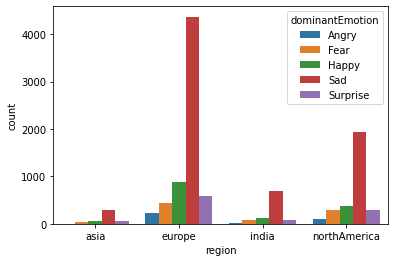

In [74]:
sns.barplot(x = "region", y = "count", hue = "dominantEmotion", data = test)

In [75]:
test['country_count_sum'] = test['count'].groupby(test['region']).transform('sum')

In [76]:
test['emotion_count_sum'] = test['count'].groupby(test['dominantEmotion']).transform('sum')

In [77]:
test['emotion_prctbycountry'] = round(test['count'] / test['country_count_sum'], 4) * 100

In [78]:
test['country_prctbyemotion'] = round(test['count'] / test['emotion_count_sum'], 4) * 100

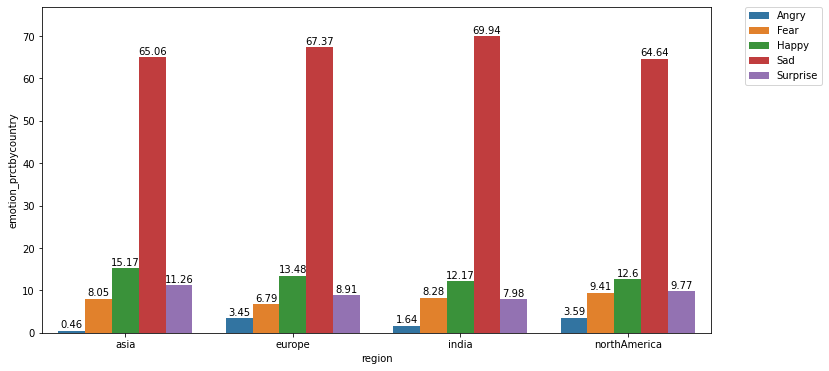

In [82]:
import matplotlib.pyplot as plt
# plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x = "region", y = "emotion_prctbycountry", hue = "dominantEmotion", data = test, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for c in ax.containers:
    # set the bar label
    ax.bar_label(c, label_type='edge', padding=1)
    
# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)